In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import json
from itertools import combinations

from knobs_functions import *

In [ ]:
# Here are the lists and dictionaries that were imported from the fetch.py file
print(f'base_list = {base_list}')
print(f'ensemble_list = {ensemble_list}')
print(f'state_chamber_list = {state_chamber_list}')
print(f'primary_score_list = {primary_score_list}')
print(f'secondary_score_list = {secondary_score_list}')
print(f'num_seats_dict = {num_seats_dict}')
print(f'ensemble_name_dict = {ensemble_name_dict}')

base_list = ['base0', 'base1', 'base2', 'base3', 'base4']
ensemble_list = ['pop_minus', 'pop_plus', 'ust', 'distpair', 'distpair_ust', 'reversible', 'county25', 'county50', 'county75', 'county100']
state_chamber_list = [('FL', 'congress'), ('FL', 'upper'), ('FL', 'lower'), ('IL', 'congress'), ('IL', 'upper'), ('IL', 'lower'), ('MI', 'congress'), ('MI', 'upper'), ('MI', 'lower'), ('NC', 'congress'), ('NC', 'upper'), ('NC', 'lower'), ('NY', 'congress'), ('NY', 'upper'), ('NY', 'lower'), ('OH', 'congress'), ('OH', 'upper'), ('OH', 'lower'), ('WI', 'congress'), ('WI', 'upper'), ('WI', 'lower')]
primary_score_list = ['Reock', 'Polsby-Popper', 'cut edges', 'Dem seats', 'efficiency gap', 'mean-median', 'partisan bias', 'competitive districts', 'average margin', 'MMD black', 'MMD hispanic', 'MMD coalition', 'county splits', 'counties split']
secondary_score_list = ['efficiency_gap_statewide', 'estimated_seats', 'disproportionality', 'pr_deviation', 'proportionality', 'efficiency_gap', 'seats_b

In [3]:
def kde_plot(state, chamber, ensemble_list, score, average_lines = True): # kde plot of any given list of ensembles
    """
    For the given state, chamber, and score, this plots one KDE for each ensembles in ensemble_list.
    """
    prop_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']  # Get the color cycle
    for i, ensemble in enumerate(ensemble_list):
        color = prop_cycle[i % len(prop_cycle)]  # Cycle through colors
        a = fetch_score_array(state, chamber, ensemble, score)
        sns.kdeplot(a, label=ensemble, color=color)
        if average_lines:
            plt.axvline(np.mean(a), linestyle='--', color=color)
    plt.title(f'{state} {chamber} {score}')
    plt.xlabel(score)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

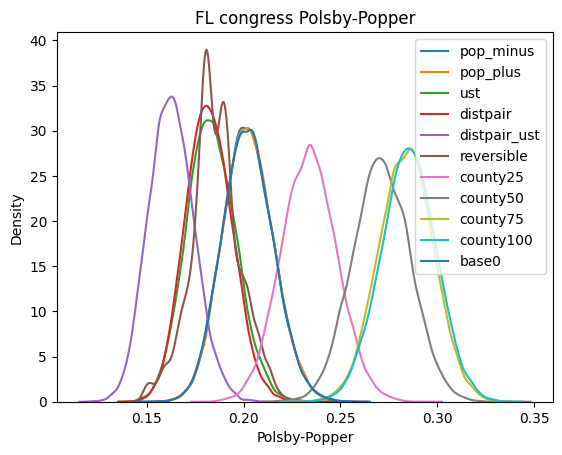

In [4]:
state = 'FL' 
chamber = 'congress'
score = 'Polsby-Popper'
kde_plot(state, chamber, ensemble_list + ['base0'], score, average_lines=False)

In [4]:
def box_plot(state, chamber, ensemble_list, competitive_window = .05):
    """
    For the given state and chamber, this superimposes ordered-seats-plots for the two ensembles in ensemble_list.
    Each ensemble is colored differently.
    The size of ensemble_list must be 2.
    It only includes seats that are competitive for at least one of the ensembles.
    (this means that the dem seat share is within competitive_window of 0.5 for at least one ensemble)
    """
    if len(ensemble_list) != 2:
        raise ValueError('ensemble_list must have length 2')
    X0 = fetch_score_array(state, chamber, ensemble_list[0], 'by_district')
    X1 = fetch_score_array(state, chamber, ensemble_list[1], 'by_district')

    seats_list = []
    for i in range(1, X0.shape[1]+1):
        if abs(np.mean(X0[:, i-1]) - 0.5) < competitive_window or abs(np.mean(X1[:, i-1]) - 0.5) < competitive_window:
            seats_list.append(i)

    fig, ax = plt.subplots(figsize=(10, 10))
    for i in seats_list:
        ax.boxplot(X0[:, i-1], positions=[i-.15], widths=0.3, patch_artist=True, 
                    boxprops=dict(facecolor='lightblue', color='black'), 
                    medianprops=dict(color='black'), 
                    flierprops=dict(markerfacecolor='white', marker=''))
        ax.boxplot(X1[:, i-1], positions=[i+0.15], widths=0.3, patch_artist=True, 
                    boxprops=dict(facecolor='lightgreen', color='black'), 
                    medianprops=dict(color='black'), 
                    flierprops=dict(markerfacecolor='white', marker=''))
    plt.xticks(np.arange(1, X0.shape[1]+1), np.arange(1, X0.shape[1]+1))
    plt.axhline(y=0.5, color='red', linestyle='--')
    plt.xlabel('Ordered Districts')
    plt.ylabel('Democrat Vote Share')
    plt.title(f'{state} {chamber}: Ordered Seats Plots for {ensemble_list[0]} and {ensemble_list[1]}')
    plt.legend([plt.Line2D([0], [0], color='lightblue', lw=4), plt.Line2D([0], [0], color='lightgreen', lw=4)],
               [ensemble_list[0], ensemble_list[1]], loc='upper left')
    plt.show()

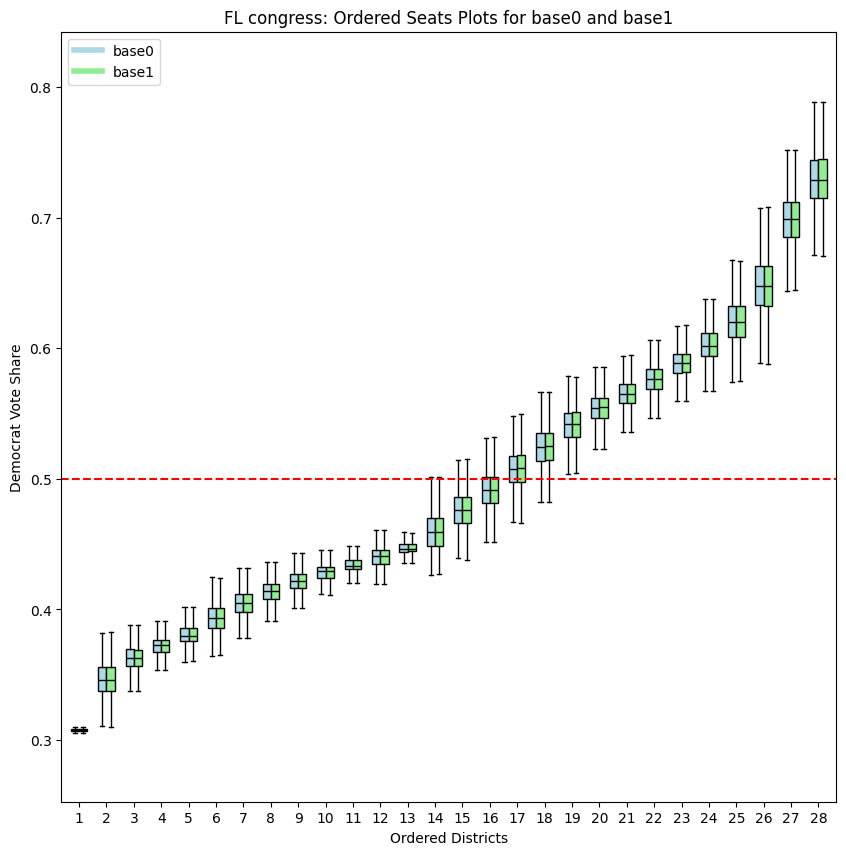

In [10]:
box_plot(state, chamber, ['base0', 'base1'], competitive_window=1)

Study the autocorrelations of individual ensembles

In [4]:
def autocorr(a): # lag 1 autocorrelation of the given array
    return np.corrcoef(a[:-1], a[1:])[0,1]

def summarize_autocorrelations(score_list, return_ESS = False):
    """
    Returns a dataframe showing (for each state-chamber pair and each ensemble type) 
    the max (over the scores) of the lag-1 autocorrelation.
    If desired, it instead returns a dataframe showing the corresponding ESSs (effective sample sizes),
    approximated from the autocorrelations via the AR(1) model.
    """
    column_list = ['base0'] + ensemble_list
    index_list = [f'{a[0]} {a[1]}' for a in state_chamber_list]
    df = pd.DataFrame(columns = column_list, index = index_list)
    for state, chamber in state_chamber_list:
        for ensemble in column_list:
            ls = []
            for score in score_list:
                a = fetch_score_array(state, chamber, ensemble, score)
                n = len(a)
                auto = np.abs(autocorr(a))
                ls.append(auto)
            maxa = max(ls)
            ESS = n*(1 - maxa)/(1 + maxa)
            if return_ESS:
                df.loc[f'{state} {chamber}', ensemble] = ESS
            else:
                df.loc[f'{state} {chamber}', ensemble] = maxa
    df = df.apply(pd.to_numeric)
    return df

In [5]:
# I'll use a restricted list of primary scores here.  The MMD scores are constant at zero for certain states and chambers, 
# which causes the autocorrelation to be infinite.

my_short_score_list = ['Reock', 'Polsby-Popper', 'cut edges', 'Dem seats', 'efficiency gap', 'mean-median',
 'partisan bias', 'competitive districts', 'average margin']
my_score_list = my_short_score_list+['counties split', 'county splits']

In [136]:
df = summarize_autocorrelations(score_list = my_score_list).round(2)
df2 = summarize_autocorrelations(score_list = my_score_list, return_ESS=True).round().astype(int)

In [ ]:
# Overlay these two dataframes into a single LaTex table that stacks their values:
pd.set_option("display.max_colwidth", None) # Prevent column truncation
color1 = "blue"
color2 = "red"
combined = pd.DataFrame(index=df.index, columns=df.columns)
for row in df.index:
    for col in df.columns:
        val1 = df.loc[row, col]
        val2 = df2.loc[row, col]
        combined.loc[row, col] = f"\\makecell{{\\textcolor{{{color1}}}{{{val1}}} \\\\ \\textcolor{{{color2}}}{{{val2}}}}}"
combined.rename(columns=ensemble_name_dict, inplace=True)
latex_table = combined.to_latex("autocorr.tex", escape=False)

In [6]:
df2_short = summarize_autocorrelations(score_list = my_short_score_list, return_ESS=True).round().astype(int)

In [7]:
df2_short

,base0,pop_minus,pop_plus,distpair,ust,distpair_ust,reversible,county25,county50,county75,county100
FL congress,17780,17864,17893,16990,18064,18418,8,17453,15316,15036,14295
FL upper,18587,17999,18794,18424,19106,18472,40,18846,16318,15558,15970
FL lower,16525,16610,16610,16493,17420,17637,8,16263,15852,15563,15762
IL congress,19493,19564,19311,19549,19654,19722,38,19479,18912,18967,18763
IL upper,18014,17934,17888,18565,18801,19224,22,18046,16582,16145,14663
IL lower,16341,16506,14951,16118,17512,17515,7,16356,15795,15479,15325
MI congress,19467,19570,19442,19363,19517,19410,65,19543,19271,18811,18988
MI upper,19273,19174,19088,19114,19594,19384,46,18870,17956,16558,16750
MI lower,17232,17026,17775,17771,18593,18366,11,16601,15461,14504,15023
NC congress,19615,19502,19551,19210,19216,19287,33,19432,19730,19475,19717


Next study the closeness of pairs of base ensembles

In [5]:
# statistical tests

def t_test(a1,a0): # runs the t-test of the hypotheses that two arrays were drawn from distributions with the same means.
    result = stats.ttest_ind(a1, a0, equal_var=False)
    return result.statistic, result.pvalue # the statistic is positive if a1 has a larger mean than a0

def ks_test(a0,a1): # runs the Kolmogorov-Smirnov test that the two arrays were drawn from the same distribution
    result = stats.ks_2samp(a0, a1)
    return result.statistic, result.pvalue, result.statistic_sign # the statistic_sign is positive if a1 has larger values than a0

def gelman_rubin_rhat(a1, a2):
    n = len(a1)
    assert len(a2) == n, "Both chains must have the same length"

    # Means and variances
    mu1, mu2 = np.mean(a1), np.mean(a2)
    s1_sq, s2_sq = np.var(a1, ddof=1), np.var(a2, ddof=1)

    W = (s1_sq + s2_sq) / 2
    B = n * ((mu1 - mu2)**2) / 2
    V_hat = ((n - 1) / n) * W + (1 / n) * B
    R_hat = np.sqrt(V_hat / W)

    return R_hat

In [22]:
def summarize_multistart(score_list = primary_score_list, dist = 'ks', combine_method = 'max'):
    column_list = score_list
    index_list = [f'{a[0]}_{a[1]}' for a in state_chamber_list]
    df = pd.DataFrame(columns = column_list, index = index_list)

    for state, chamber in state_chamber_list:
        for score in primary_score_list:
            ls = []
            for ensemble1, ensemble2 in combinations(base_list,2):
                a1 = fetch_score_array(state, chamber, ensemble1, score)
                a0 = fetch_score_array(state, chamber, ensemble2, score)
                t_statistic, t_pvalue = t_test(a1, a0)
                ks_statistic, ks_pvalue, ks_sign = ks_test(a0, a1)

                if dist == 'ks':
                    ls.append(ks_statistic)
                elif dist == 't':
                    ls.append(t_statistic)
                elif dist == 'gelman':
                    ls.append(gelman_rubin_rhat(a1, a0))
            if combine_method == 'max':
                df.loc[f'{state}_{chamber}', score] = max(ls)
            elif combine_method == 'mean':
                df.loc[f'{state}_{chamber}', score] = np.mean(ls)
            elif combine_method == 'list':
                df.loc[f'{state}_{chamber}', score] = np.array(ls)
    return df           

In [9]:
df_multi = summarize_multistart()

In [13]:
df_multi = df_multi.apply(pd.to_numeric, errors='coerce')  # Convert columns to numeric
df_multi.round(2)  # Round the numeric values to 2 decimal places

,Reock,Polsby-Popper,cut edges,Dem seats,efficiency gap,mean-median,partisan bias,competitive districts,average margin,MMD black,MMD hispanic,MMD coalition,county splits,counties split
FL_congress,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.00,0.01,0.01,0.01,0.02
FL_upper,0.02,0.01,0.01,0.01,0.01,0.02,0.01,0.01,0.02,0.00,0.01,0.01,0.01,0.01
FL_lower,0.02,0.01,0.01,0.01,0.02,0.01,0.02,0.01,0.01,0.01,0.03,0.01,0.01,0.01
IL_congress,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.01,0.01,0.01,0.00,0.01,0.01,0.01
IL_upper,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
IL_lower,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.01
MI_congress,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.00,0.01,0.01,0.01
MI_upper,0.02,0.02,0.02,0.01,0.02,0.01,0.01,0.01,0.02,0.01,0.00,0.00,0.01,0.01
MI_lower,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.01,0.01,0.01,0.00,0.01,0.01,0.01
NC_congress,0.01,0.01,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.00,0.00,0.00,0.01,0.01


In [14]:
largest_value = df_multi.max().max()
largest_value

0.02535000000000001

In [25]:
largest_value = df_multi_R.max().max()
largest_value

1.0004491097894619

In [19]:
df_multi.round(2).to_latex('multistart.tex')

C:\Users\ktapp\AppData\Local\Temp\ipykernel_8152\659986146.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df_multi.round(2).to_latex('multistart.tex')


In [6]:
# make dictionaries from which later dataframes will be created.
# Each dictionary will map (state, chamber, ensemble, score) to a specific measurement of closeness to the base0 ensemble.

mean_diff_dict = {}
KS_stat_dict = {}
KS_pvalue_dict = {}
T_pvalue_dict = {}

for state, chamber in state_chamber_list:
    for score in primary_score_list + secondary_score_list:
        a0 = fetch_score_array(state, chamber, 'base0', score)
        for ensemble in ['base1', 'base2', 'base3', 'base4'] + ensemble_list:
            a1 = fetch_score_array(state, chamber, ensemble, score)
            mean_diff = np.mean(a1) - np.mean(a0)
            KS_stat, KS_pvalue, KS_sign = ks_test(a0, a1)
            KS_signed_stat = KS_stat * KS_sign
            _, T_pvalue = t_test(a1, a0)

            mean_diff_dict[(state, chamber, ensemble, score)] = mean_diff
            KS_stat_dict[(state, chamber, ensemble, score)] = KS_signed_stat
            KS_pvalue_dict[(state, chamber, ensemble, score)] = KS_pvalue
            T_pvalue_dict[(state, chamber, ensemble, score)] = T_pvalue

c:\Users\ktapp\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\ktapp\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [7]:
def mean_diff_table(score, pvalue = None, latex_filename = None, rounding = 2):
    """
    Returns a dataframe showing (for each state-chamber pair and each ensemble type)
    the mean-difference between that ensemble and the base0 ensemble with respect to the given score.
    If pvalue is set, it will mark values that are significantly different from the base0 ensemble.
    if latex_filename is set, it will also save the dataframe as a latex table.

    Args:
        score: use any valid score, or use 'Dem share' for 'Dem seats' divided by the number of seats.
        p_value: set to None if you don't want marks.
    """

    index_list = [f'{a[0]} {a[1]}' for a in state_chamber_list] + ['AVERAGE']
    columns_list = ['base1']+ ensemble_list
    df = pd.DataFrame(columns = columns_list, index = index_list)
    df_mark = df.copy() # True/False signifying whether the value is marked as statistically significant

    effective_score = 'Dem seats' if score == 'Dem share' else score
    for state, chamber in state_chamber_list:
        denom = num_seats_dict[(state, chamber)] if score == 'Dem share' else 1
        for ensemble in columns_list:
            mean_diff = mean_diff_dict[(state, chamber, ensemble, effective_score)] / denom
            mean_diff = np.round(mean_diff, 2)
            p_value = T_pvalue_dict[(state, chamber, ensemble, effective_score)]
            df.loc[f'{state} {chamber}', ensemble] = mean_diff
            df_mark.loc[f'{state} {chamber}', ensemble] = (pvalue != None and p_value < pvalue)
    df.loc['AVERAGE'] = df.mean().round(rounding)
    df = df.round(rounding) 
    df_latex = df.copy()

    # combine the values and markings into dataframes to return and for Latex
    for state, chamber in state_chamber_list:
        for ensemble in columns_list:
            if df_mark.loc[f'{state} {chamber}', ensemble]:
                df_latex.loc[f'{state} {chamber}', ensemble] = f'\\textbf{{{df.loc[f"{state} {chamber}", ensemble]}}}'
                df.loc[f'{state} {chamber}', ensemble] = f'*{df.loc[f"{state} {chamber}", ensemble]}'

    if latex_filename is not None:
        df_latex.rename(columns=ensemble_name_dict, inplace=True)
        df_latex.to_latex(latex_filename, escape=False)
    return df

In [8]:
for score in primary_score_list:
    T = mean_diff_table(score, pvalue=.001)
    T.to_csv(f'score_tables/primary/{score}.csv')
for score in secondary_score_list:
    T = mean_diff_table(score, pvalue=.001)
    T.to_csv(f'score_tables/secondary/{score}.csv')

In [12]:
def make_table(my_score_list = primary_score_list, my_ensemble_list= ensemble_list, my_state_chamber_list=state_chamber_list,
               based_on = 'ks_p', threshold = .001, display_extremes = True, transpose = True):
    """
    Create a dataframe whose columns are the scores and whose rows are the ensembles.
    Each cell contains a string of +, -, or 0, one for each state-chamber, to compare that ensemble's score to that of the base0 ensemble.
    if based_on == 'ks', the symbol indicates whether the KS statistic is above the threshold.
    if based_on == 'ks_p', it indicates whether the KS pvalue is below the threshold.
    if based_on == 't_p', it indicates whether the t-test pvalue is below the threshold.
    if display_extremes is True, the cell will also contain a dictionary with the state-chamber with 
    the largest and smallest KS-statistic (or mean-difference statistics if based_on='t_p').

    It returns the transpose if transpose is True.
    """
    df = pd.DataFrame(columns=my_score_list, index=my_ensemble_list).fillna('')
    for score in my_score_list:
        for ensemble in my_ensemble_list:
            string_of_symbols = ''
            min_stat = 0
            max_stat = 0
            max_state_chamber = ''
            min_state_chamber = ''
            for state, chamber in my_state_chamber_list:
                md = mean_diff_dict[state, chamber, ensemble, score]
                ks = KS_stat_dict[state, chamber, ensemble, score]
                ks_p = KS_pvalue_dict[state, chamber, ensemble, score]
                t_p = T_pvalue_dict[state, chamber, ensemble, score]

                if based_on == 'ks':
                    if np.abs(ks) > threshold:
                        x = '+' if ks > 0 else '-'
                    else:
                        x = '0'
                if based_on == 't_p':
                    if t_p < threshold:
                        x = '+' if md > 0 else '-'
                    else:
                        x = '0'
                elif based_on == 'ks_p':
                    if ks_p < threshold:
                        x = '+' if ks > 0 else '-'
                    else:
                        x = '0'
                string_of_symbols += x
                
                if x in ['+', '-']:
                    stat = ks if based_on in ['ks', 'ks_p'] else md
                    if stat > max_stat:
                        max_stat = stat
                        max_state_chamber = f'{state}_{chamber}'
                    if stat < min_stat:
                        min_stat = stat
                        min_state_chamber = f'{state}_{chamber}'

            if display_extremes:
                D = dict()
                if max_stat > 0:
                    D[max_state_chamber] = np.round(max_stat,3)
                if min_stat < 0:
                    D[min_state_chamber] = np.round(min_stat,3)
                if len(D) > 0:
                    df.at[ensemble, score] = f'{string_of_symbols}{D}'
                else:
                    df.at[ensemble, score] = string_of_symbols
            else:
                df.at[ensemble, score] = string_of_symbols

    if transpose:
        df = df.transpose()
    return df

In [ ]:
# test that the other 4 base ensembles are all close to base0
test = make_table(my_ensemble_list=['base1', 'base2', 'base3', 'base4'],
                    based_on = 'ks_p', threshold = .001, display_extremes=False)
test

In [16]:
compact_score_list = ['Reock', 'Polsby-Popper', 'cut edges']
partisan_score_list = ['Dem seats', 'efficiency gap', 'mean-median', 'partisan bias', 'competitive districts', 'average margin']
other_score_list = ['MMD coalition', 'county_splits']

base_ensemble_list = ['base1', 'base2', 'base3', 'base4']
ensemble_list = ['pop_minus', 'pop_plus', 'ust', 'distpair', 'distpair_ust', 'reversible', 
                'county25', 'county50', 'county75', 'county100']
county_ensemble_list = ['county25', 'county50', 'county75', 'county100']
pop_ensemble_list = ['pop_minus', 'pop_plus']
recom_ensemble_list = ['ust', 'distpair', 'distpair_ust', 'reversible']

In [18]:
T = make_table(my_ensemble_list=pop_ensemble_list)
#T.to_csv('pop_knob.csv')
T

,pop_minus,pop_plus
Reock,"00000+0-000000000000+{'IL_lower': 0.025, 'MI_u...",0000000+0000000000000{'MI_upper': 0.025}
Polsby-Popper,0--0000-000-0--000000{'MI_upper': -0.083},0+000+0++0+000+000000{'MI_upper': 0.047}
cut edges,0++0++0++00+0++00+000{'MI_upper': 0.056},0--0--0--0-00--0000--{'FL_lower': -0.035}
Dem seats,00000000000000000000+{'WI_lower': 0.02},000000000000000000000
efficiency gap,"0000+00+00-000000000-{'IL_upper': 0.029, 'WI_l...","000+-00+00000000000-0{'MI_upper': 0.023, 'IL_u..."
mean-median,0000+0000000000000000{'IL_upper': 0.021},000000000000000000000
partisan bias,0000000000000--000000{'NY_lower': -0.026},00000-000000000000000{'IL_lower': -0.021}
competitive districts,0000-0000000000000000{'IL_upper': -0.024},0000+0000000000000000{'IL_upper': 0.021}
average margin,00-000000000000000000{'FL_lower': -0.023},"0+00000000000--000000{'FL_upper': 0.029, 'NY_u..."
MMD black,000000000000000000000,000000000000000000000


In [19]:
T = make_table(my_ensemble_list=recom_ensemble_list)
#T.to_csv('recom_knob.csv')
T

,ust,distpair,distpair_ust,reversible
Reock,---------------------{'NY_lower': -0.537},---------------------{'NY_lower': -0.664},---------------------{'NY_lower': -0.922},---------------------{'OH_lower': -0.858}
Polsby-Popper,---------------------{'NY_lower': -0.848},---------------------{'NY_lower': -0.95},---------------------{'NY_lower': -1.0},---------------------{'NY_lower': -0.937}
cut edges,+++++++++++++++++++++{'NY_lower': 0.943},+++++++++++++++++++++{'NY_lower': 0.988},+++++++++++++++++++++{'NY_lower': 1.0},+++++++++++++++++++++{'FL_lower': 0.996}
Dem seats,"-00++0+0000000+-0-+0-{'MI_congress': 0.051, 'O...","--0+00++00+0+0+00-+--{'NY_congress': 0.054, 'F...","--0++0++0-+0+0+---+--{'NY_lower': 0.1, 'FL_con...","--+-+-++++++--++-+++-{'NY_lower': 0.455, 'FL_c..."
efficiency gap,"+00+---000-0+0-+0+-0+{'OH_congress': 0.056, 'M...","++0-00--00-0-0-+0+-++{'FL_congress': 0.073, 'N...","++0-----0+-0---+++-++{'FL_congress': 0.122, 'M...","++-+-+------++--+---+{'FL_congress': 0.361, 'F..."
mean-median,"+00000-00+-0-0-+--00-{'OH_congress': 0.09, 'MI...","0+++0+--00--+00+---+-{'OH_congress': 0.054, 'M...","0+++00---+---00+---+-{'OH_congress': 0.146, 'M...","++-+-+--+--+-+-+++-++{'FL_upper': 0.323, 'NC_u..."
partisan bias,"++0-0---00-0-0-+---0+{'OH_congress': 0.129, 'M...","++0-++---0-0-0-+-0-0+{'FL_upper': 0.073, 'MI_c...","++0-++---0-0---+---++{'OH_congress': 0.182, 'M...","++---+--+---+--++---+{'IL_lower': 0.34, 'FL_lo..."
competitive districts,"+00000-00+++-++0+00-+{'FL_congress': 0.078, 'N...","+0000+-+00++00+0+0+-+{'FL_congress': 0.117, 'W...","++++++-+00++-++-+0+-+{'FL_congress': 0.217, 'M...","+-++-+-+--+--++-----+{'NC_upper': 0.337, 'NC_l..."
average margin,"---+--------+--------{'IL_congress': 0.039, 'F...",---------0-----------{'FL_congress': -0.181},---------------------{'FL_congress': -0.329},"-+----+--+--+--+---++{'OH_congress': 0.248, 'I..."
MMD black,00-0--0-00-----00-00-{'OH_lower': -0.085},"00-------0--0--0--0+-{'WI_upper': 0.023, 'OH_l...",00-------0-----0--00-{'OH_lower': -0.189},"0+---+++-0-+-++0--0++{'IL_lower': 0.177, 'MI_l..."


In [20]:
T = make_table(my_ensemble_list=county_ensemble_list)
#T.to_csv('county_knob.csv')
T

,county25,county50,county75,county100
Reock,+++++++++0+++++0++0++{'NC_lower': 0.329},+++++++++++++++++++++{'NC_lower': 0.651},+++++++++++++++++++++{'NC_lower': 0.781},+++++++++++++++++++++{'NC_lower': 0.796}
Polsby-Popper,+++++++++++++++++++++{'NC_upper': 0.887},+++++++++++++++++++++{'OH_upper': 1.0},+++++++++++++++++++++{'NC_upper': 1.0},+++++++++++++++++++++{'IL_lower': 1.0}
cut edges,---------------------{'NY_congress': -0.676},---------------------{'NY_congress': -0.954},---------------------{'NC_upper': -0.98},---------------------{'NC_upper': -0.979}
Dem seats,"++--0--0+-++-+0000-0+{'FL_congress': 0.167, 'W...","++--0--++-++-+0+-0--+{'FL_congress': 0.236, 'W...","++-----++-++-+++-0--+{'FL_congress': 0.215, 'W...","+++----++-++-+++-0--+{'FL_congress': 0.212, 'W..."
efficiency gap,"--++0++--+--+-0-+0+0-{'WI_congress': 0.115, 'F...","--++0++--+--+-0-+0++-{'WI_congress': 0.27, 'FL...","--+++++--+--+---+-++-{'WI_congress': 0.279, 'F...","--0++++--+--+---+-++-{'WI_congress': 0.276, 'F..."
mean-median,"-0--+++0-+--++0++-+-+{'WI_lower': 0.135, 'FL_c...","---+++-0-+--+++++-+++{'WI_lower': 0.26, 'FL_co...","---++++0-+--+++++-+++{'WI_lower': 0.277, 'OH_l...","---++++0-+--+++++-+-+{'WI_lower': 0.289, 'OH_l..."
partisan bias,"--00-000-+-----0+-+++{'WI_upper': 0.145, 'FL_c...","--+0-0+--+-----++-+++{'WI_congress': 0.267, 'N...","--+0-++--+-----++-+++{'WI_upper': 0.289, 'NY_u...","---0+++--+-----++-+++{'WI_upper': 0.293, 'NY_l..."
competitive districts,"+-+-0+0-+0-0-----+-+-{'WI_upper': 0.102, 'WI_l...","--+++++-+----0---+-+-{'WI_upper': 0.176, 'WI_l...","--+++++-+----0---+-+-{'IL_lower': 0.202, 'WI_l...","--+++++-+----0---+-+-{'IL_lower': 0.237, 'WI_l..."
average margin,"+++-++++-++++0+++++++{'WI_lower': 0.307, 'IL_c...",+++++++++++++++++++++{'WI_lower': 0.563},"+++++-+++++++++++++++{'WI_lower': 0.662, 'IL_l...","+++++-+++++++++++++++{'WI_lower': 0.733, 'IL_l..."
MMD black,"00-0++00-0++++00000++{'WI_lower': 0.075, 'MI_l...","00-++++--0+++++0000++{'WI_lower': 0.167, 'MI_l...","00-++++--0+++++00-0++{'WI_lower': 0.217, 'FL_l...","00-++++--0+++++00-0++{'WI_lower': 0.243, 'MI_l..."


In [ ]:
def score_table(score, pvalue = None):
    """
    Returns a dataframe showing (for each state-chamber pair and each ensemble type)
    the mean-difference between that ensemble and the base0 ensemble with respect to the given score.
    If pvalue is set, it will mark * next to all values that are significantly different from the base0 ensemble.

    Args:
        score: use any valid score, or use 'Dem share' for 'Dem seats' divided by the number of seats.
        p_value: set to None if you don't want * marks.
    """

    index_list = [f'{a[0]}_{a[1]}' for a in state_chamber_list]
    columns_list = ['base1']+ ensemble_list
    df = pd.DataFrame(columns = columns_list, index = index_list)
    effective_score = 'Dem seats' if score == 'Dem share' else score
    for state, chamber in state_chamber_list:
        denom = num_seats_dict[(state, chamber)] if score == 'Dem share' else 1
        for ensemble in columns_list:
            mean_diff = mean_diff_dict[(state, chamber, ensemble, effective_score)] / denom
            mean_diff = np.round(mean_diff, 2)
            p_value = T_pvalue_dict[(state, chamber, ensemble, effective_score)]

            if pvalue == None or p_value > pvalue:
                df.loc[f'{state}_{chamber}', ensemble] = f'{mean_diff}'
            else:
                df.loc[f'{state}_{chamber}', ensemble] = f'*{mean_diff}'

    return df

In [47]:
score_table('Dem seats', pvalue=.001)

,base1,pop_minus,pop_plus,ust,distpair,distpair_ust,reversible,county25,county50,county75,county100
FL_congress,0.0,0.01,0.0,*-0.11,*-0.18,*-0.29,*-0.83,*0.42,*0.59,*0.56,*0.55
FL_upper,0.02,-0.01,0.02,-0.02,*-0.09,*-0.14,*-0.57,*0.07,0.04,*0.05,*0.1
FL_lower,0.01,0.03,0.03,-0.0,0.01,-0.06,*1.69,*-0.12,*-0.21,*-0.09,*0.07
IL_congress,0.0,-0.01,-0.0,0.01,*0.03,*0.04,*-0.05,*-0.06,*-0.23,*-0.23,*-0.21
IL_upper,-0.01,-0.03,0.04,*0.1,-0.01,*0.09,*0.37,-0.03,0.0,*-0.07,*-0.15
IL_lower,0.01,0.03,0.0,*0.08,-0.05,0.01,*-0.67,*-0.14,*-0.14,*-0.22,*-0.35
MI_congress,-0.0,0.0,0.0,*0.06,*0.05,*0.09,*0.24,*-0.04,*-0.16,*-0.26,*-0.27
MI_upper,-0.01,-0.0,-0.03,0.03,*0.07,*0.18,0.03,0.01,*0.11,*0.13,*0.14
MI_lower,-0.03,-0.02,0.01,-0.06,0.03,0.04,*0.27,*0.23,*0.46,*0.53,*0.48
NC_congress,0.01,0.01,-0.0,*-0.05,*-0.03,*-0.08,*0.42,*-0.04,*-0.07,*-0.08,*-0.09


In [48]:
score_table('competitive districts', pvalue=.001)

,base1,pop_minus,pop_plus,ust,distpair,distpair_ust,reversible,county25,county50,county75,county100
FL_congress,-0.02,-0.04,-0.01,*0.3,*0.46,*0.88,*0.38,-0.03,*-0.09,*-0.11,*-0.1
FL_upper,-0.02,-0.02,*-0.06,0.05,0.03,*0.16,*-0.18,*-0.14,*-0.31,*-0.37,*-0.43
FL_lower,0.05,0.09,-0.0,*0.14,*0.11,*0.19,*0.12,*0.45,*0.39,*0.28,*0.44
IL_congress,-0.0,-0.02,-0.01,0.02,*0.04,*0.06,*0.15,*-0.16,0.01,*0.06,*0.05
IL_upper,-0.04,*-0.12,*0.1,*0.07,*0.08,*0.21,*-0.1,*-0.07,*0.13,*0.26,*0.37
IL_lower,0.0,-0.02,0.05,*0.1,*0.25,*0.34,*0.71,*0.23,*0.78,*1.43,*1.65
MI_congress,0.0,-0.01,-0.0,*-0.06,*-0.07,*-0.15,-0.02,0.01,*0.07,*0.12,*0.1
MI_upper,-0.02,0.03,-0.04,0.01,*0.35,*0.43,*1.02,*-0.1,*-0.08,*-0.07,-0.06
MI_lower,0.02,-0.02,-0.03,-0.07,-0.08,-0.08,*-0.19,*0.34,*0.63,*0.76,*0.76
NC_congress,-0.01,0.0,0.01,*0.05,-0.01,0.04,*-0.2,0.0,*-0.08,*-0.14,*-0.16


In [54]:
for score in primary_score_list:
    T = score_table(score)
    T.to_csv(f'score_tables/primary/{score}.csv')
for score in secondary_score_list:
    T = score_table(score)
    T.to_csv(f'score_tables/secondary/{score}.csv')

Next, let's study how close the ordered seat plot of an ensemble is from that of the base0 ensemble

In [ ]:
def Compare_ordered_seats(competitive_window = .05, metric = 'mean_diff', combine_method = 'max',
                          plot_threshold = None):
    """
    Returns a dataframe showing (for each state-chamber pair and each ensemble type) 
    the "distance" between the ordered seats plots of the ensemble and the base0 ensemble.
    It only considers seats that are competitive for at least one of the two ensembles being compared,
    (which means that dem share is within competitive_window of 0.5 for at least one of the two ensembles).
    Args:
        competitive_window: the window around 0.5 that defines a competitive seat (default .05)
        metric: 'mean_diff' or 'ks' to measure, for each seat, the distance between the two histograms 
        combine_method: 'max', 'mean' (default 'max')
        plot_threshold: if not None, it plots an ordered-seats plot for each cell of the returned dataframe past the threshold.
    """
    index_list = [f'{a[0]}_{a[1]}' for a in state_chamber_list]
    columns_list = ['base1', 'pop_minus', 'pop_plus', 'ust', 'distpair', 'distpair_ust', 'reversible','county25', 'county50', 'county75', 'county100']
    df = pd.DataFrame(columns = columns_list, index = index_list)
    for state, chamber in state_chamber_list:
        for ensemble in columns_list:
            X0 = fetch_score_array(state, chamber, 'base0', 'by_district')
            X1 = fetch_score_array(state, chamber, ensemble, 'by_district')
            num_seats = X0.shape[1]
            ls = []
            for i in range(num_seats):
                if abs(np.mean(X0[:, i]) - 0.5) < competitive_window or abs(np.mean(X1[:, i]) - 0.5) < competitive_window:
                    if metric == 'mean_diff':
                        closeness = abs(np.mean(X1[:, i]) - np.mean(X0[:, i]))
                    elif metric == 'ks':
                        closeness, _, __ = ks_test(X1[:, i], X0[:, i])
                    else:
                        raise ValueError('metric must be mean_diff or ks')
                    ls.append(closeness)
                    
            combined_closeness = max(ls) if combine_method == 'max' else np.mean(ls)
            df.loc[f'{state}_{chamber}', ensemble] = combined_closeness
            if plot_threshold is not None and combined_closeness > plot_threshold:
                box_plot(state, chamber, [ensemble, 'base0'], competitive_window=competitive_window)
    df = df.apply(pd.to_numeric)
    return df

In [35]:
df = Compare_ordered_seats(metric = 'mean_diff')

In [36]:
df.round(2)

,base1,pop_minus,pop_plus,ust,distpair,distpair_ust,county25,county50,county75,county100
FL_congress,0.0,0.0,0.0,0.0,0.0,0.01,0.01,0.01,0.01,0.01
FL_upper,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00
FL_lower,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00
IL_congress,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.01,0.01,0.01
IL_upper,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00
IL_lower,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00
MI_congress,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.01,0.01
MI_upper,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00
MI_lower,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00
NC_congress,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00


In [79]:
dfm = Compare_ordered_seats(metric='ks')

In [80]:
dfm.round(2)

,base1,pop_minus,pop_plus,ust,distpair,distpair_ust,county25,county50,county75,county100
FL_congress,0.02,0.02,0.02,0.09,0.13,0.24,0.18,0.30,0.30,0.29
FL_upper,0.02,0.04,0.07,0.02,0.04,0.07,0.06,0.11,0.13,0.16
FL_lower,0.01,0.03,0.01,0.03,0.03,0.05,0.07,0.09,0.09,0.09
IL_congress,0.01,0.01,0.01,0.07,0.04,0.06,0.09,0.21,0.25,0.25
IL_upper,0.01,0.02,0.03,0.04,0.03,0.07,0.05,0.13,0.17,0.20
IL_lower,0.01,0.02,0.02,0.04,0.03,0.07,0.04,0.13,0.22,0.26
MI_congress,0.01,0.01,0.01,0.09,0.07,0.15,0.04,0.15,0.21,0.22
MI_upper,0.01,0.03,0.05,0.02,0.08,0.14,0.04,0.10,0.13,0.14
MI_lower,0.01,0.02,0.02,0.02,0.04,0.04,0.08,0.19,0.25,0.26
NC_congress,0.01,0.01,0.03,0.03,0.03,0.07,0.03,0.08,0.12,0.12


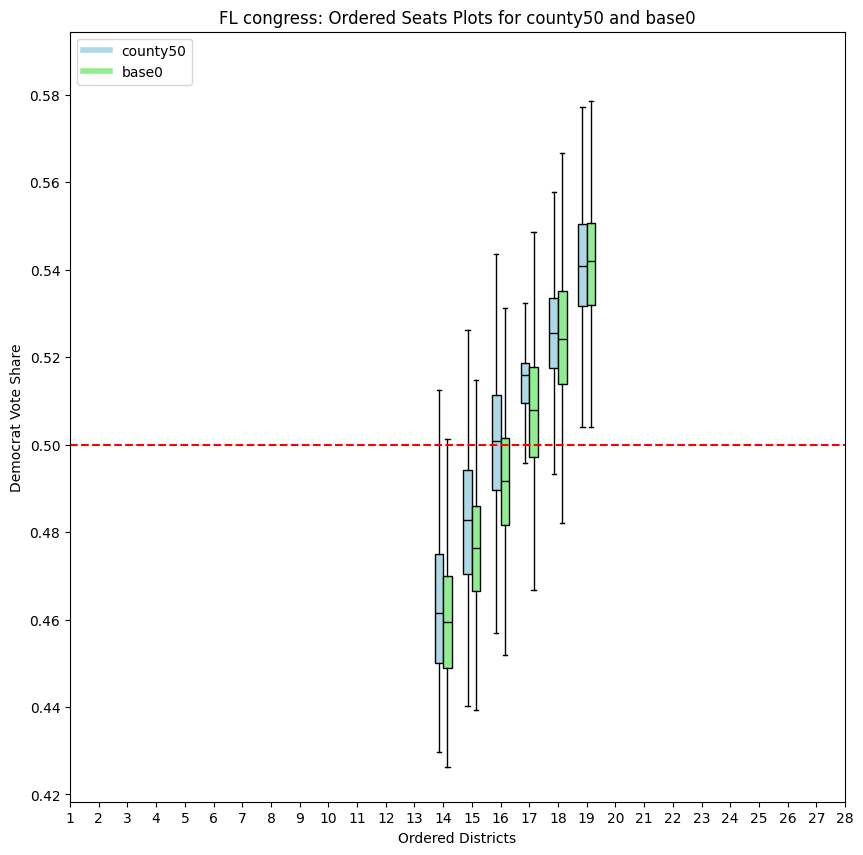

In [81]:
# let's look at a particular ensemble with a high KS-value:
box_plot('FL', 'congress', ['county50', 'base0'], competitive_window=.05)

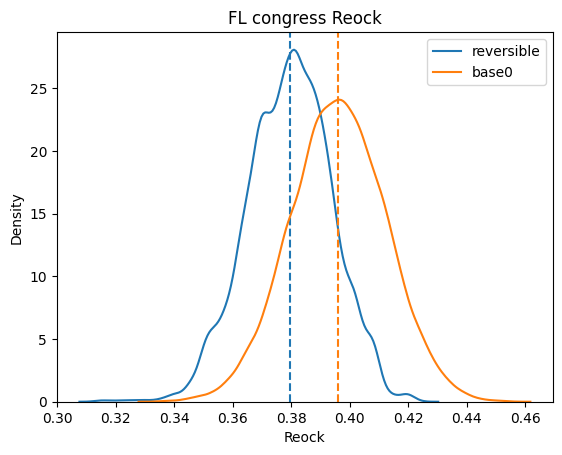

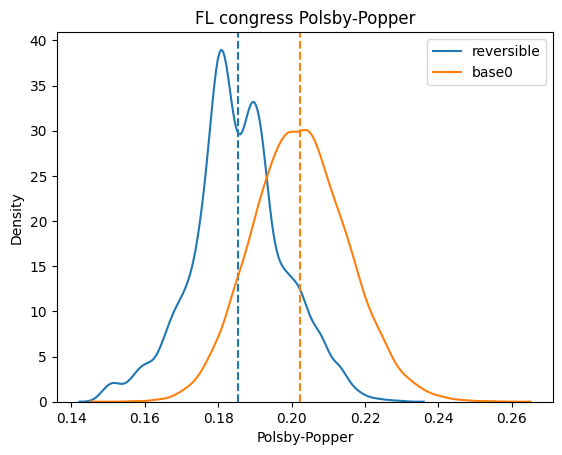

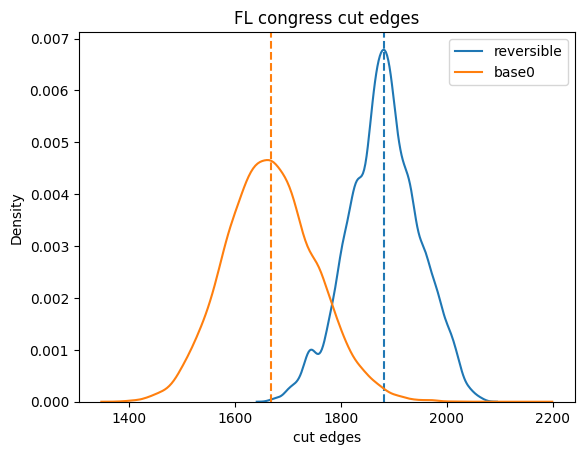

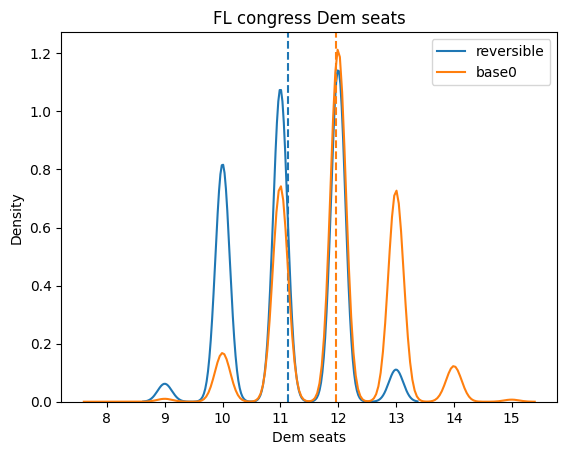

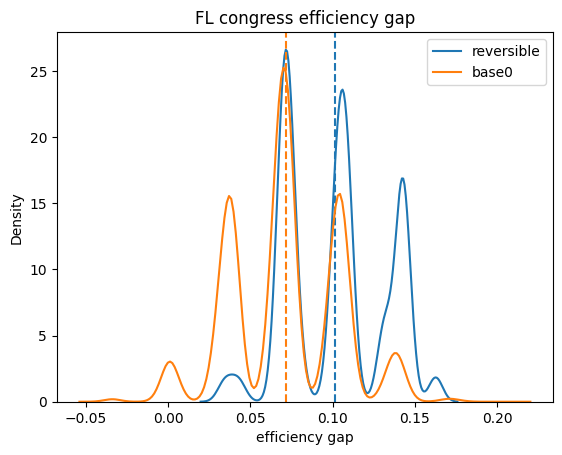

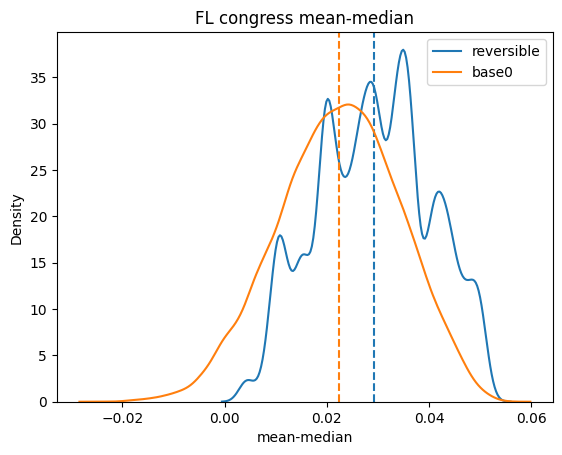

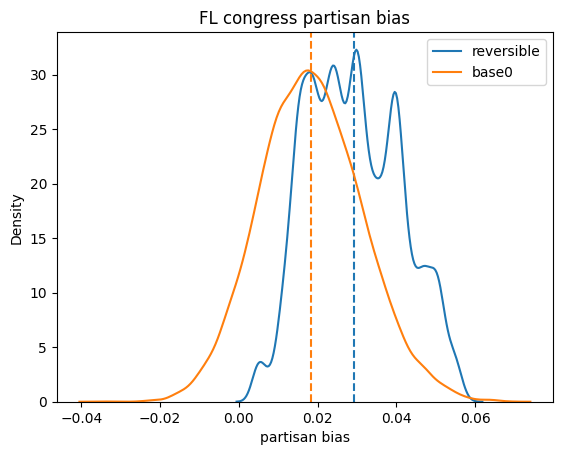

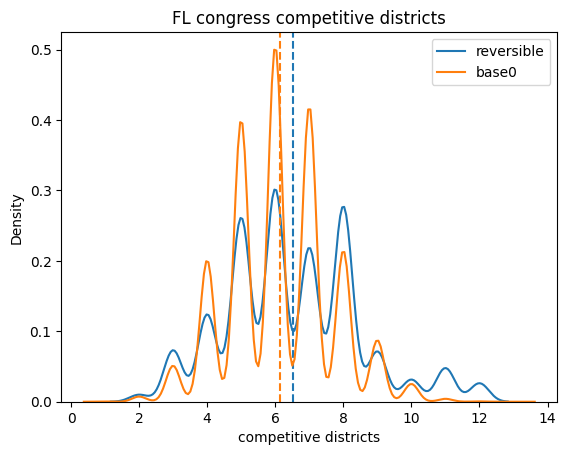

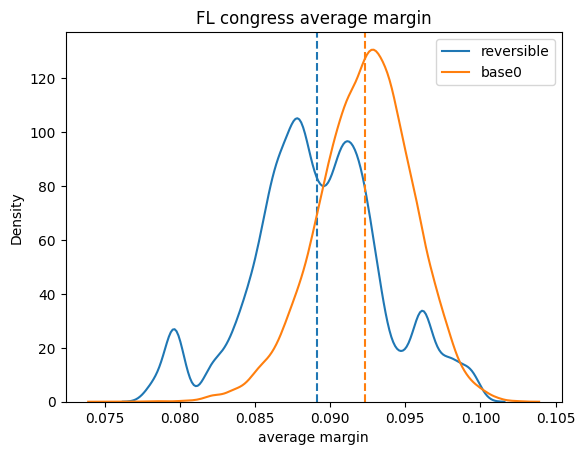

C:\Users\ktapp\AppData\Local\Temp\ipykernel_15904\1760162745.py:9: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(a, label=ensemble, color=color)
C:\Users\ktapp\AppData\Local\Temp\ipykernel_15904\1760162745.py:9: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(a, label=ensemble, color=color)
C:\Users\ktapp\AppData\Local\Temp\ipykernel_15904\1760162745.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


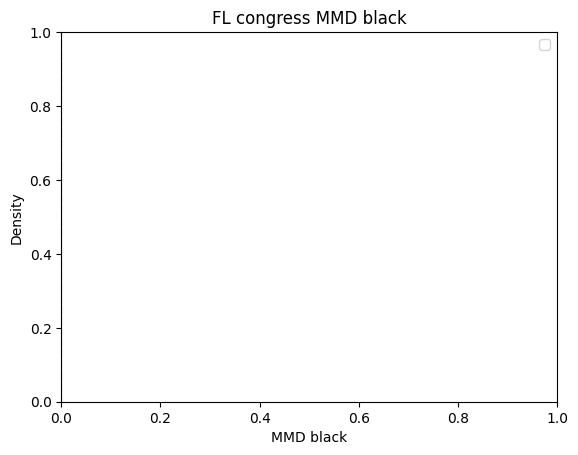

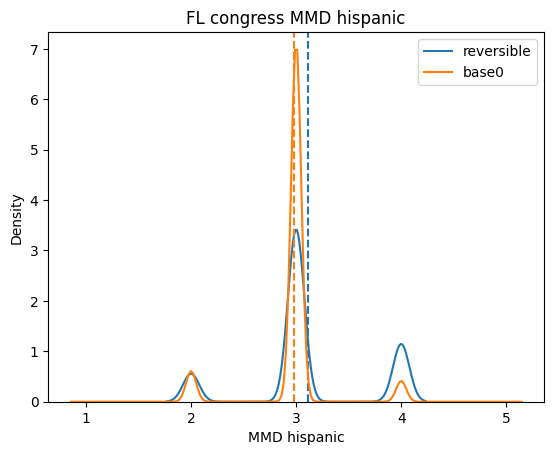

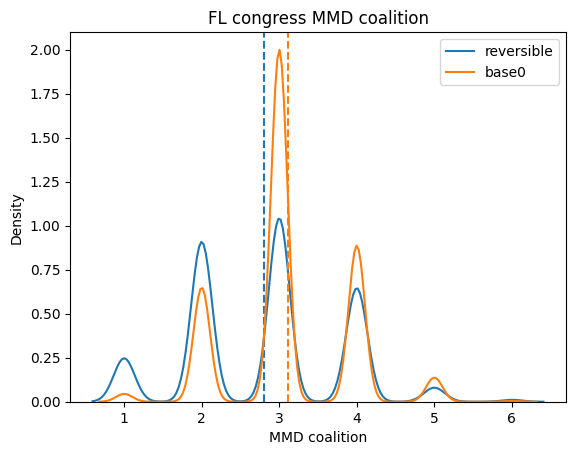

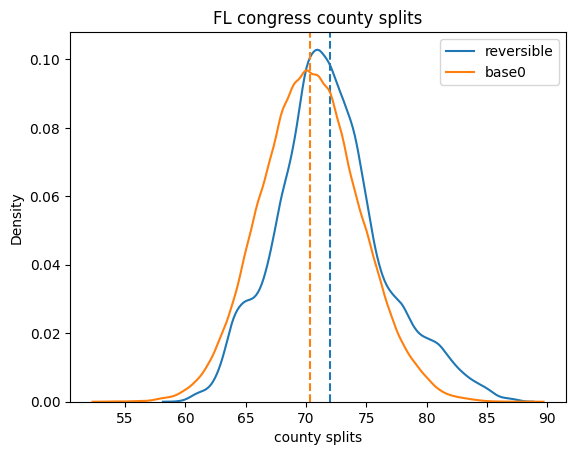

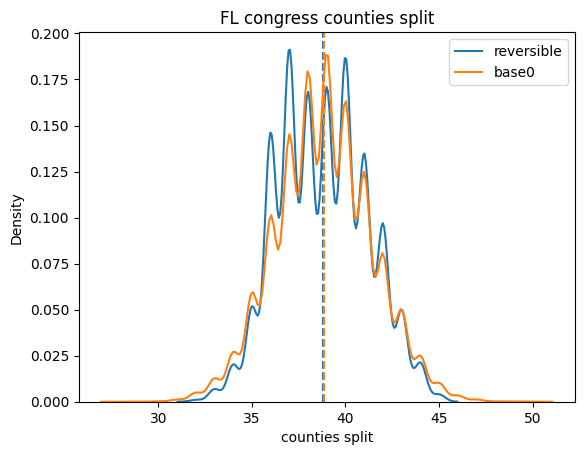

In [55]:
state = 'FL'
chamber = 'congress'
ensemble = 'reversible'
for score in primary_score_list:
    kde_plot(state, chamber, [ensemble, 'base0'], score)